# A Toxic Comment Identifier Application - Data Transformation Notebook

In this notebook, we will perform additional data transformation on our datasets such as LSA (Latent Semantic Analysis) and PCA.  We will explore whether reducing the datasets would be something beneficial for our models.

The very first step is to import all packages needed to perform data transformation.

In [ ]:
#Load the libraries
import numpy as np
import pandas as pd
import seaborn as sns
import pickle
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.cm as cm
import nltk
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer

from sklearn.decomposition import TruncatedSVD,PCA
from sklearn import preprocessing, model_selection, metrics
from sklearn.model_selection import GridSearchCV, ParameterGrid
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.metrics import f1_score, mean_squared_error,accuracy_score,v_measure_score, silhouette_score
from sklearn.model_selection import cross_val_score, RepeatedStratifiedKFold,train_test_split, StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

First, we read the clean_data which was originally saved from the Toxic_App_Explaratory_Data_Cleaning.ipynb notebook.

In [17]:
file_object = open('clean_data1.p', 'rb')
clean_data = pickle.load(file_object)
file_object.close()
train = clean_data[0]
test = clean_data[1]

Next, we validate the shape of our datasets.

In [18]:
train.shape

(4398, 5)

In [19]:
test.shape

(1516, 5)

We then validate the counts of all the toxicity levels.

In [20]:
train['toxicity_level'].value_counts()

3    1595
1    1433
2    1370
Name: toxicity_level, dtype: int64

The categories is as follows:
* 1 - Non-Toxic
* 2 - Toxic
* 3 - Severe Toxic

Looking at the counts above, we have a fairly balanced set for the training data.  Next, we define functions that give us insight into what type of terms we are working with.  The method topNwords and topTermsByClass will give us a better sense of the word breakdown by class.

In [25]:
def topNwords(data,topN=5):
    vec= CountVectorizer(stop_words='english',analyzer='word').fit(data)
    bagOfW= vec.transform(data)
    sumWord= bagOfW.sum(axis=0)
    wordFreq= [(word,sumWord[0,idx])for word, idx in vec.vocabulary_.items()]
    wordFreq= sorted(wordFreq,key=lambda x:x[1], reverse=True)
    topTerm= pd.DataFrame(wordFreq[:topN], columns=["Term","Count"])
    return topTerm

def topTermByClass(data, topN=10):
    ''' Expecting the data with two columns, one with comment_text, the other
    with its toxicity_level. Return a list of dataframes for each of the class in the toxicity_level,
    where each dataframe contains topN terms and their tfidf value'''
    dfs=[]
    for level in np.unique(data['toxicity_level']):
        idx= data['toxicity_level'].index[data['toxicity_level']==level]
        topTerm= topNwords(data.loc[idx]['comment_text'],topN= 10)
        dfs.append(topTerm)
    type=['non_toxic','toxic','severe_toxic']
    plt.figure(figsize=(10,8))
    plt.suptitle("Top Terms Per Toxicity Level",fontsize=10)
    plt.rcParams["figure.autolayout"] = True
    gridspec.GridSpec(2,2)
    for termClass in range(2):
        plt.subplot2grid((2,2),(0,termClass))
        sns.barplot(x=dfs[termClass]['Term'],y=dfs[termClass]['Count'])
        plt.title((f"Toxicity Class:{type[termClass]}"),fontsize=8)
        plt.xlabel('Word', fontsize=7)
        plt.xticks(fontsize=7)
        plt.yticks(fontsize=7)
        plt.ylabel('Count', fontsize=7)
    row2Ind= 2
    for row2 in range(2):
        plt.subplot2grid((2,2),(1,row2))
        sns.barplot(x=dfs[row2Ind]['Term'],y=dfs[row2Ind]['Count'])
        plt.title((f"Toxicity Class:{type[row2Ind]}"),fontsize=8)
        plt.xlabel('Word', fontsize=7)
        plt.xticks(fontsize=7)
        plt.yticks(fontsize=7)
        plt.ylabel('Count', fontsize=7)
        row2Ind +=1
    plt.show()
    return dfs

IndexError: list index out of range

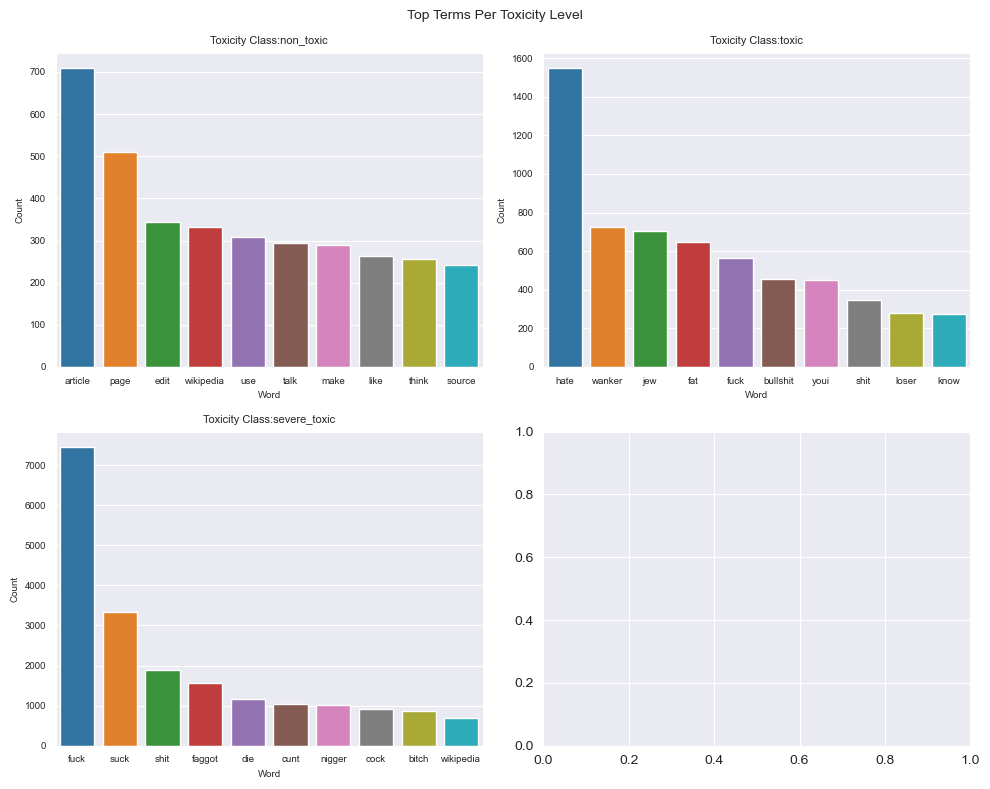

In [26]:
trainSub= train[['comment_text','toxicity_level']]
x= topTermByClass(trainSub,10)

In [7]:
##Since the mild_toxicity does not differ much from the non_toxicity group based on the topterm and kmean plot,
##ditch mild_toxicity 
train= train[train.toxicity_level !=2]
train['toxicity_level']= train['toxicity_level'].replace([3,4],[2,3])
train= train.drop(columns=['mild_toxicity'])
train['toxicity_level'].value_counts()

/var/folders/c4/lz0fty3s6b3148w_cbvkndwm0000gn/T/ipykernel_3717/3628352486.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['toxicity_level']= train['toxicity_level'].replace([3,4],[2,3])


3    1595
1    1433
2    1370
Name: toxicity_level, dtype: int64

In [8]:
with open('Train_3L', 'wb') as file_object:
    pickle.dump(train, file_object)
file_object.close()

In [9]:
picklefile= open('Train_3L','rb')
train=pickle.load(picklefile)
picklefile.close()

In [10]:
def TFIDF_func(data):
    vectorizer= TfidfVectorizer(smooth_idf=True, sublinear_tf=False, norm=None, 
                         analyzer='word')
    txt_fitted= vectorizer.fit(data)
    txt_tranformed = txt_fitted.transform(data) 
    X_tfidf= txt_tranformed.toarray()
    terms= txt_fitted.get_feature_names_out()
    return X_tfidf, terms

X_tfidf, terms= TFIDF_func(train['comment_text'])
X_tfidf

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [27]:
# LSA and Plot for Cumulative_explained_variance vs n_componenets
def LSA(X, list_comp): 
    EVar=[] 
    for n_comp in list_comp:
        lsa= make_pipeline(TruncatedSVD(n_components=n_comp), 
                           Normalizer(copy=False))
        lsa.fit(X)
        explainedVar = lsa[0].explained_variance_ratio_.sum()
        EVar.append(explainedVar)
        print("Number of components = %r and explained variance = %r"%(n_comp,explainedVar))
    plt.plot(list_comp,EVar, linewidth=2)
    plt.xlabel('n_components')
    plt.ylabel('Cumulative Explained Variance')
    plt.title("Cumulative Explained Variance VS N_components")
    plt.show()

14842
Number of components = 142 and explained variance = 0.9894495532740597
Number of components = 132 and explained variance = 0.9887224826049971
Number of components = 122 and explained variance = 0.987617015902027
Number of components = 112 and explained variance = 0.9859020002560606
Number of components = 102 and explained variance = 0.9822722101969145
Number of components = 92 and explained variance = 0.9754591980483318
Number of components = 82 and explained variance = 0.9629564151611557
Number of components = 72 and explained variance = 0.9455413614545015
Number of components = 62 and explained variance = 0.9208919358127485
Number of components = 52 and explained variance = 0.8864915865051481
Number of components = 42 and explained variance = 0.8252860588249398
Number of components = 32 and explained variance = 0.737702816341966
Number of components = 22 and explained variance = 0.6204804495449984
Number of components = 12 and explained variance = 0.4526663228577077
Number of c

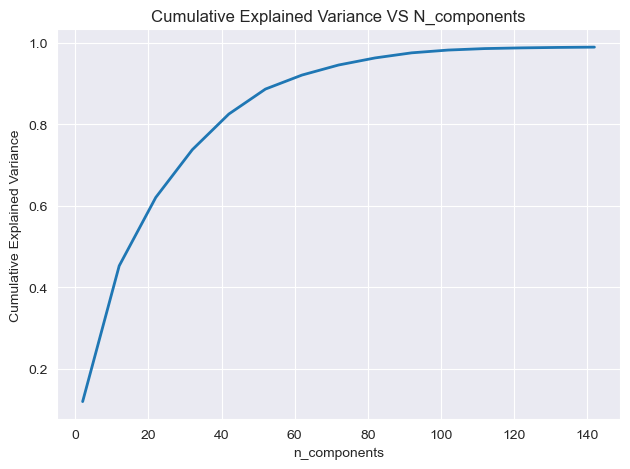

In [13]:
step=10
column= X_tfidf.shape[1] 
print(column)
LSA(X_tfidf,range(column-(1470*step),0,-step))

## Question to explore: Will tsvd perform differently on diff algothrim?

In [14]:
skf= StratifiedKFold(n_splits=5,shuffle=True,random_state=961)
target= np.array(train['toxicity_level'])
w=[]
#loop through the value for svd dimension parameter
for n in range(110,100,-1): #negative step to let range decrease from start
    log=[]
    for train_index, test_index in skf.split(X_tfidf,target):
        xTrain, xTest= X_tfidf[train_index,:],X_tfidf[test_index,:]
        yTrain,yTest= target[train_index],target[test_index]
        lsa= make_pipeline(TruncatedSVD(n_components=n), Normalizer(copy=False))
        xTrain_lsa= lsa.fit_transform(xTrain)
        xTest_lsa= lsa.transform(xTest)    
        explainedVar = lsa[0].explained_variance_ratio_.sum()
        sdg_params = { 
            'loss': ['log','hinge','modified_huber'], 
            'penalty': ['l2','elasticnet'],
            "alpha" : [0.0001, 0.001, 0.01, 0.1],
            'n_jobs': [-1]
            }
        model= SGDClassifier(max_iter= 3000,random_state=961)
        grid= GridSearchCV(model, param_grid=sdg_params,cv=5)
        grid.fit(xTrain_lsa,yTrain)
        #model= LogisticRegression(solver='lbfgs',multi_class="multinomial").fit(xTrain_lsa,yTrain)

        BModel= SGDClassifier(**grid.best_params_, max_iter= 3000,random_state=961)
        BModel.fit(xTrain_lsa,yTrain)

        f1Train= f1_score(yTrain,BModel.predict(xTrain_lsa),average='micro')
        f1Test= f1_score(yTest,BModel.predict(xTest_lsa),average='micro') 
        AccTest= accuracy_score(yTest,BModel.predict(xTest_lsa))
        log.append([f1Train,f1Test,AccTest])
    print("For n_component= %r with explained variance = %r,the best parameters are: %r"%(n, explainedVar,grid.best_params_))
    
    mean= np.mean(log,axis=0)
    F1_train= mean[0]
    F1_test= mean[1]
    Accu_Test= mean[2]

    w.append([n,F1_train, F1_test, Accu_Test])  
svd_dm= pd.DataFrame(w,columns=['N',"F1_Train","F1_Test","Accuracy _Test"])

For n_component= 110 with explained variance = 0.9873730311698026,the best parameters are: {'alpha': 0.0001, 'loss': 'log', 'n_jobs': -1, 'penalty': 'elasticnet'}
For n_component= 109 with explained variance = 0.9872742383946264,the best parameters are: {'alpha': 0.0001, 'loss': 'log', 'n_jobs': -1, 'penalty': 'elasticnet'}
For n_component= 108 with explained variance = 0.987173764734415,the best parameters are: {'alpha': 0.0001, 'loss': 'log', 'n_jobs': -1, 'penalty': 'l2'}
For n_component= 107 with explained variance = 0.987066159596329,the best parameters are: {'alpha': 0.0001, 'loss': 'log', 'n_jobs': -1, 'penalty': 'elasticnet'}
For n_component= 106 with explained variance = 0.9869556644945431,the best parameters are: {'alpha': 0.0001, 'loss': 'log', 'n_jobs': -1, 'penalty': 'l2'}
For n_component= 105 with explained variance = 0.9868437639232589,the best parameters are: {'alpha': 0.0001, 'loss': 'log', 'n_jobs': -1, 'penalty': 'l2'}
For n_component= 104 with explained variance = 0

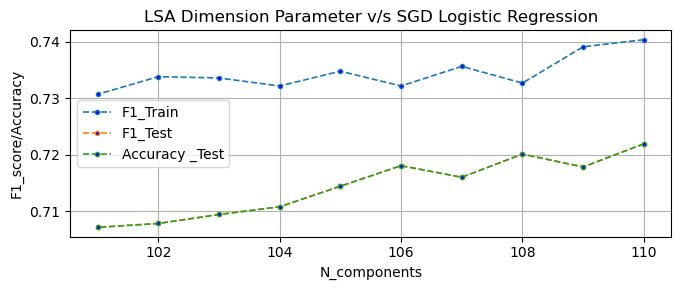

,N,F1_Train,F1_Test,Accuracy _Test
0,110,0.740337,0.721918,0.721918


In [15]:
kwargs = dict (linestyle='dashed', linewidth=1.2,marker='o',
               markerfacecolor='blue', markersize=3)
line_plot= svd_dm.plot(x="N",figsize=(7,3),**kwargs)
line_plot.set_title('LSA Dimension Parameter v/s SGD Logistic Regression')
line_plot.grid()
line_plot.set_xlabel('N_components')
line_plot.set_ylabel('F1_score/Accuracy')
plt.show()
bestN= svd_dm[svd_dm.index==svd_dm['F1_Test'].argmax()]
bestN


In [19]:
##Try go with n_comp=110
lsa= make_pipeline(TruncatedSVD(n_components=110), Normalizer(copy=False))
XLSA= lsa.fit_transform(X_tfidf)

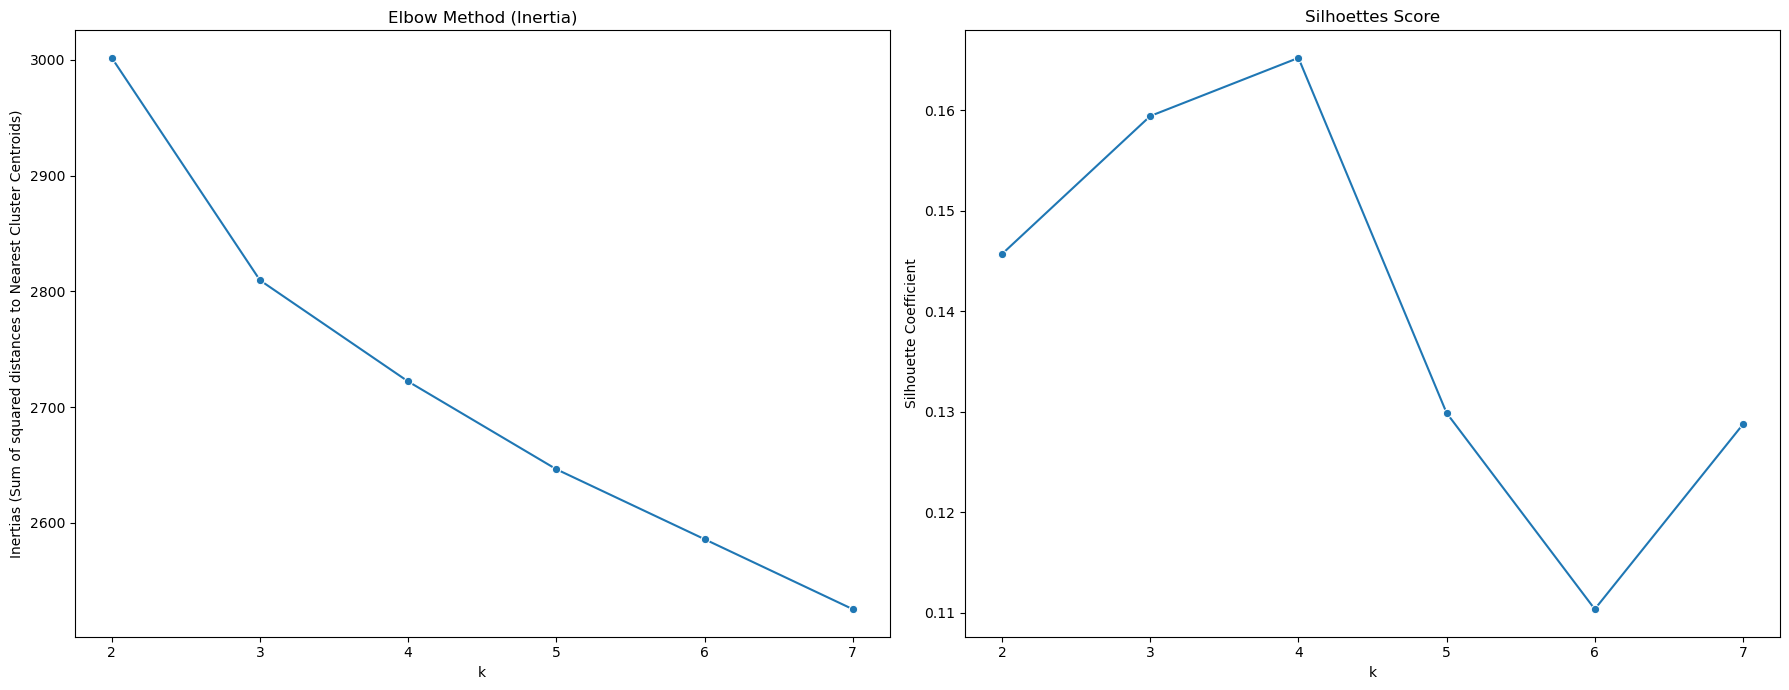

In [17]:
log = [] 
k_range = range(2,8) # Range of k values

for k in k_range:
    kmean = KMeans(n_clusters = k, random_state=961)
    clusterLabel = kmean.fit_predict(XLSA)
    inertia= kmean.inertia_
    centroids= kmean.cluster_centers_
    if True: # Generate Silhoettes Score
        silhoettes_avg = silhouette_score(XLSA, clusterLabel)
        log.append([k, inertia, silhoettes_avg])
        continue
    log.append([k, inertia])

plot_df = pd.DataFrame(
    log, columns = [
        'k', 'Inertias (Sum of squared distances to Nearest Cluster Centroids)', 'Silhouette Coefficient'
        ]
    )
fig, axes = plt.subplots(1,2, figsize=(18,7))
sns.lineplot(
    x='k', y='Inertias (Sum of squared distances to Nearest Cluster Centroids)', 
    data = plot_df, marker= 'o', ax = axes[0])
axes[0].set_title("Elbow Method (Inertia)")
sns.lineplot(x='k', y='Silhouette Coefficient', data=plot_df, marker='o', ax = axes[1])
axes[1].set_title("Silhoettes Score")
plt.show()

In [18]:
def silhouette_analysis_with_pca(n_clusters,X):
    
    # K-Mean Clustering
    kmean = KMeans(n_clusters = n_clusters, random_state=961)
    clusterLabel = kmean.fit_predict(X)
    centroids= kmean.cluster_centers_

    # Compute Individual Silhoette Score
    silhoettes_avg = silhouette_score(X, clusterLabel)

    # Compute Average Silhoette Score
    sample_silhouette_values = silhouette_samples(X, clusterLabel)
     # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    ################################### Silhouette Plot #############################################
 
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_xlim([-0.1, 1])
    y_lower = 10

    # Assign colours for different cluster
    for i in range(n_clusters):
         # Aggregate the silhouette scores for samples belonging to
         # cluster i, and sort them
         ith_cluster_silhouette_values = sample_silhouette_values[clusterLabel == i]
         ith_cluster_silhouette_values.sort()
         size_cluster_i = ith_cluster_silhouette_values.shape[0]
         y_upper = y_lower + size_cluster_i
         color = cm.nipy_spectral(float(i) / n_clusters)
         ax1.fill_betweenx(np.arange(y_lower, y_upper),
                           0, ith_cluster_silhouette_values,
                           facecolor=color, edgecolor=color, alpha=0.7)
         
         ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
         y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("Silhouette Plot for Clusters.")
    ax1.set_xlabel("Silhouette Coefficient Values")
    ax1.set_ylabel("Cluster Label")
    # avg sil score 
    ax1.axvline(x=silhoettes_avg, color="red", linestyle="--")
    ax1.set_yticks([]) 
    ax1.set_xticks([-0.2, 0, 0.2, 0.4, 0.6, 0.8])

    ################################### SVD Plot #############################################
 
    # Compute tsvd with only First 2 Number of Component
    tsvd2 = TruncatedSVD(n_components=2)
    sample2 = tsvd2.fit_transform(X)

    ##Getting diff color for diff cluster 
    colors = cm.nipy_spectral(clusterLabel.astype(float) / n_clusters)
    ax2.scatter(sample2[:,0], sample2[:,1], marker='.', s=70, lw=0, alpha=1,
            c=colors, edgecolor='k')

    centers = centroids.dot(tsvd2.components_.T) # Cluster Positions after transformation 
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                 c="white", alpha=1, s=200, edgecolor='k')
    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')
    ax2.set_title("The visualization of TSVD with total explained variance of {:.2f}%.".format(tsvd2.explained_variance_ratio_.sum()*100))
    ax2.set_xlabel("Feature space for the 1st component")
    ax2.set_ylabel("Feature space for the 2nd component")
    plt.suptitle(("Silhouette analysis for KMeans clustering on Toxic Comment Dataset"
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

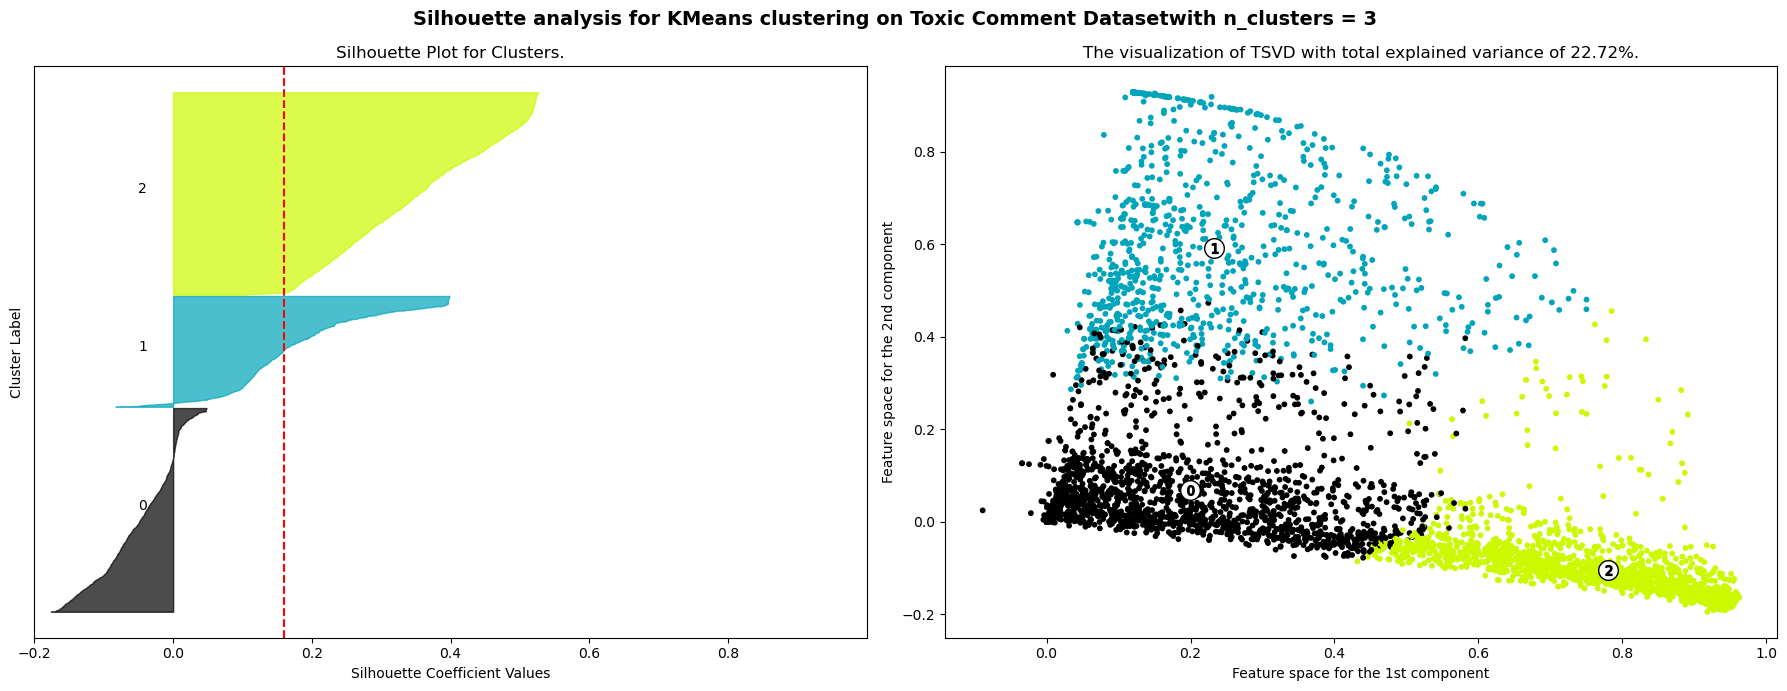

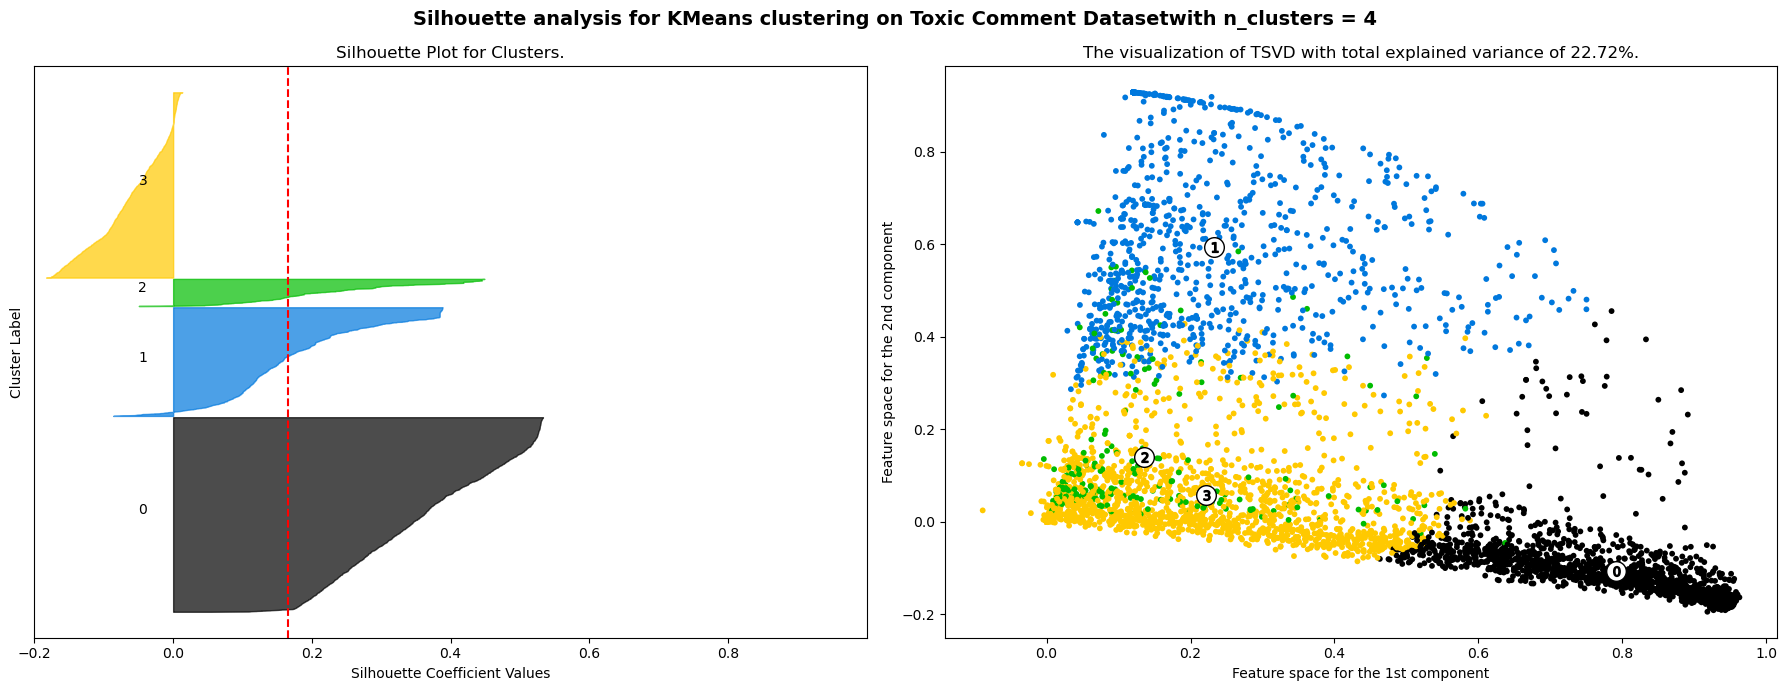

In [19]:
for i, k in enumerate(range(3,5)): # Analyse k = (3,4)
    silhouette_analysis_with_pca(n_clusters = k, X = XLSA)
    plt.show()

In [20]:
#go with k=3
kmean3 = KMeans(n_clusters = 3, random_state=961)
clusterLabel3 = kmean3.fit_predict(XLSA)
centroids3= kmean3.cluster_centers_

Cluster 0: fuck go shit bitch youre asshole cunt as faggot wikipedia ---- sever toxic 
Cluster 1: suck go bitch youre as shit wikipedia article asshole get ---- toxic
Cluster 2: article people make page like get use one source add ------ non-toxic 

In [24]:
original_space_centroids = lsa[0].inverse_transform(kmean3.cluster_centers_)
order_centroids = original_space_centroids.argsort()[:, ::-1]
labels = train.toxicity_level
unique_labels, category_sizes = np.unique(labels, return_counts=True)
true_k = unique_labels.shape[0]

for i in range(true_k):
    print(f"Cluster {i}: ", end="")
    for ind in order_centroids[i, :10]:
        print(f"{terms[ind]} ", end="")
    print()


Cluster 0: fuck go shit bitch youre asshole cunt as faggot wikipedia 
Cluster 1: suck go bitch youre as shit wikipedia article asshole get 
Cluster 2: article people make page like get use one source add 


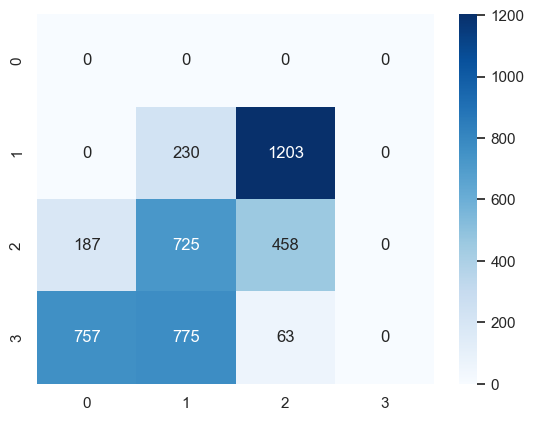

In [28]:
from sklearn.metrics import confusion_matrix
confuM= confusion_matrix(labels,kmean3.labels_)
sns.set()
ax=sns.heatmap(confuM,annot=True,fmt="d",cmap="Blues")

In [39]:
from sklearn import utils
from scipy.optimize import linear_sum_assignment as linear_assignment
import numpy as np
def cluster_accuracy(y_true, y_pred):
    confusionM = metrics.confusion_matrix(y_true, y_pred)
    _costM = lambda x:-x + np.max(confusionM)
    indexes = linear_assignment(_costM(confusionM))
    indexes = np.concatenate([indexes[0][:,np.newaxis],indexes[1][:,np.newaxis]], axis=-1)
    js = [e[1] for e in sorted(indexes, key=lambda x: x[0])]
    cm2 = confusionM[:, js]
    accuracy = np.trace(cm2) / np.sum(cm2)
    return accuracy

In [41]:
cluster_accuracy(labels,kmean3.labels_)

0.6105047748976807

In [11]:
file_object = open('clean_data1.p', 'rb')
clean_data = pickle.load(file_object)
file_object.close()
train3,test = clean_data[0],clean_data[1]
test.head(3)


,comment_text,non_toxic,toxic,severe_toxic,toxicity_level
152094,open shut case httpwwwdailymailcouknewsarticle...,1.0,0.0,0.0,1
29806,richard k clearly axe grind,1.0,0.0,0.0,1
24494,relevant manual style require title list defin...,1.0,0.0,0.0,1


In [53]:
X_test, terms= TFIDF_func(test['comment_text'])
xTest_LSA= lsa.fit_transform(X_test)
predictedCluster= kmean3.predict(xTest_LSA)
predictedCluster
cluster_accuracy(test['toxicity_level'],predictedCluster)

0.3865435356200528

In [51]:
X_test

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

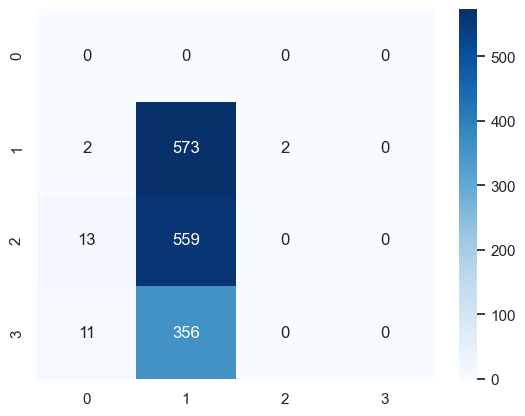

In [54]:
confuT= confusion_matrix(test['toxicity_level'],predictedCluster)
sns.set()
ax=sns.heatmap(confuT,annot=True,fmt="d",cmap="Blues")